## Calculation of $\pi$   
1. Generate two random numbers from a uniform distribution on (0, 1).  
2. Use these numbers as a coordinate (x, y) of the trial shot.  
3. If the distance to the shot is within the unit circle, then it is hit and otherwise it is miss.  
4. $\pi \approx \frac{\displaystyle 4 \times \text{(the number of hit)} }{\displaystyle \text{(the number of shots)} }$

In [1]:
import numpy as np
import random
from random import random
import scipy.stats as st

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
S = 100001 # total number of trials
freq = 1000 # interval at which pi is calculated
pi_approx = []
hit = 0

for i in range(S):
    coord = (random(), random())
    x = coord[0]
    y = coord[1]
    r2 = x**2 + y**2
    if r2 <= 1.0:
        hit = hit + 1
    if i%freq==1:
        pi_approx.append(4*(hit/i))

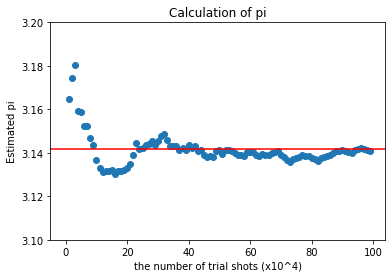

In [3]:
plt.xlabel('the number of trial shots (x10^4)')
plt.ylabel('Estimated pi')
plt.title('Calculation of pi')
plt.ylim(3.10, 3.20)
plt.axhline(3.1415926545, color='red')
plt.scatter(list(range(len(pi_approx))), pi_approx)

In [4]:
print(pi_approx[-1])
print(np.pi)

3.140735952162099
3.141592653589793


## Simulate and Draw Histrogram of $X_1$ and $\Pi X_i$  
Explain how to use a Markov Chain Monte Carlo method to generate the value of a random vector $X_1, ..., X_{10}$ whose distribution is approximately the conditional distribution of 10 independent exponential random variables with common mena 1 given that $\Pi_{i=1}^{10} X_i > 20$  
\- Gibbs Sampler  
\- Memoryless property of exponential distribution  
  
**probability distribution of $X_1, ... X_{10}$**  
$f(X_1, ..., x_{10}) = \frac{\displaystyle \Pi_{i=1}^{10} e^{-X_i}}{\displaystyle Pr(\Pi_{i=1}^{10} X_i > 20)}$  

In [5]:
def pi(arr):
    """arr 안의 모든 원소를 곱하는 함수"""
    if len(arr)==1:
        return arr[0]
    else:
        a = arr[-1]
        result = a*pi(arr[:-1]) # recursion
        return result

Gibbs sampling 에서 x1.....x10 까지 다 full conditional 아래에서 새로 추출해야함. xj를 추출할 차례라면?

=> xj를 새로 뽑는데 x1....x10 까지의 곱이 20보다 크다는 조건 아래에서 뽑아야함.

=> xj을 제외한 x1...x10 의 곱이 만약 10이라면, xj 은 2보다 커야함

기본 논리: xseq 에서 x1 업데이트, x2 업데이트....x10 까지 업데이트 하고 xseq 을 sampling 으로 accept

첫번째 방법: 그냥 시뮬레이션.. xj 를 exp(1) 에서 2가 넘을때까지 뽑기

두 번째 방법: xj는 지수분포이므로 memoryless property 를 이용해서 해당 conditional distribution 을 구할 수 있음.
  
Goal : 위의 pdf를 만족하는 길이 10인 X 벡터를 MCMC를 통해 sampling하기!  
-> 우리는 각각의 $X_i$가 평균이 1인 지수분포를 따른다는 사실을 알고 있으므로 임의로 초기값을 지정한 뒤 full conditional distribution을 간주하고 (초기값은 문제의 조건을 만족하여 full conditional distribution이 되도록 지정) 하나의 X를 sampling한다. 조금 더 일반화하여 생각하면 Xj를 제외한 곱이 m이라면 Xj는 20/m보다 커야 업데이트할 수 있다. 그렇게 10개 원소에 대해 한 바퀴를 돌고 나면 10번 업뎃된 xseq를 하나의 sample로 accept.

In [6]:
x1history1 = []; # x1 sampling history of method 1
x1history2 = []; # x1 sampling history of method 2
pixhistory1 = []; # pix sampling history of method 1
pixhistory2 = []; # pix sampling history of method 2

In [7]:
# method 1 : Using Gibbs Sampler

xseq1 = [1, 2, 2.5, 1.1, 1.15, 4.8, 0.7, 0.8, 1.2, 1.01];
# pi(xseq)=20 에서 너무 벗어나지 않도록 임의로 설정

# sanity check
print(pi(xseq1))

for i in range(10000):
    for j in range(10):
        xjcandidate = st.expon.rvs(); # xj 를 exp 에서 후보 뽑기
        xseqcandidate = xseq1; # x(j-1) 까지 업데이트 되었던 xseq 가져오기
        xseqcandidate[j] = xjcandidate; # [x1,x2,,,,xj,,,,x10] 후보 새롭게 구성
        if pi(xseqcandidate)>20: # 새롭게 구성한 [x1,x2,,,,xj,,,,x10] pi 값 확인
            xseq1 = xseqcandidate; # 20이 넘는다면 후보를 accept
        else:
            while pi(xseqcandidate)<=20: # pi 가 20이 안 넘으면 넘을때까지...
                xjcandidate = st.expon.rvs();
                xseqcandidate[j] = xjcandidate;
            xseq1 = xseqcandidate; # 넘었으니 accept
    x1history1.append(xseq1[0]); # x1~x10 까지 전부 업데이트한 xseq 을 sampling 으로 accept, 그중 x1 sampling 모으기
    pixhistory1.append(pi(xseq1)); # pi x sampling 모으기

20.605939199999995


In [8]:
# method 2 : Memoryless Property

xseq2 = [.9, 2.1, 2.45, 1.15, 1.1, 4.9, 0.75, 0.77, 1.24, 0.98]; 
# pi(xseq)=20 에서 너무 벗어나지 않도록 임의로 설정

# sanity check
print(pi(xseq2))

for k in range(10000):
    for l in range(10):
        xother = xseq2[:l]+xseq2[l+1:];
        piother = pi(xother); # xl 빼고 나머지 값들의 곱
        minimum = 20/piother; # xl 이 가져야 하는 최솟값
        xseq2[l] = st.expon.rvs(minimum)
        # st.expon.rvs(a) = random sampling of f(x)=exp(-(x-a)), x>=a
    x1history2.append(xseq2[0]); # x1~x10 까지 전부 업데이트한 xseq 을 sampling 으로 accept, 그중 x1 sampling 모으기
    pixhistory2.append(pi(xseq2)); # pi x sampling 모으기

20.1425404052565


Burn-in : after red vline

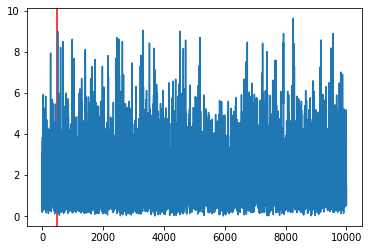

In [9]:
xaxis=list(range(1, len(x1history1)+1))
plt.axvline(500, color='red')
plt.plot(xaxis, x1history1);

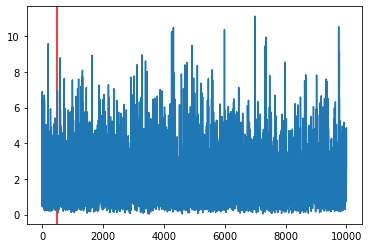

In [10]:
plt.axvline(500, color='red')
plt.plot(xaxis, x1history2);

In [11]:
# 잘라내고 500번째 이후만 고려하기
x1history1 = x1history1[500:];
pixhistory1 = pixhistory1[500:];
x1history2 = x1history2[500:];
pixhistory2 = pixhistory2[500:];
xaxis=list(range(1, len(x1history1)+1))

method 1로 Xj의 분포를 보나 method 2로 보나 모두 결과가 유사하다.

1.9108191846790705


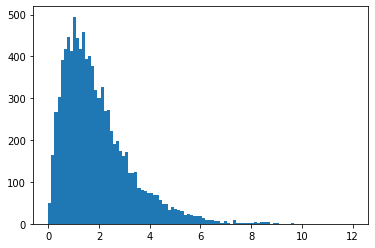

In [12]:
mean1 = sum(x1history1)/len(x1history1)
print(mean1)
xaxis = np.linspace(0,12,100)
plt.hist(x1history1, bins=xaxis);

1.921586259347604


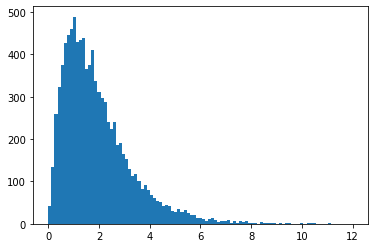

In [13]:
mean2 = sum(x1history2)/len(x1history2)
print(mean2)
plt.hist(x1history2, bins=xaxis);

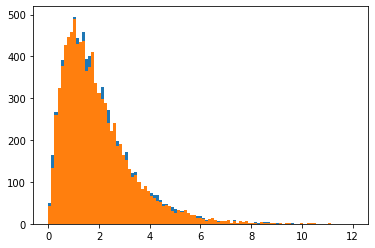

In [14]:
plt.hist(x1history1, bins=xaxis);
plt.hist(x1history2, bins=xaxis);

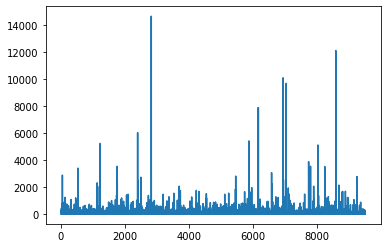

In [15]:
plt.plot(pixhistory1);

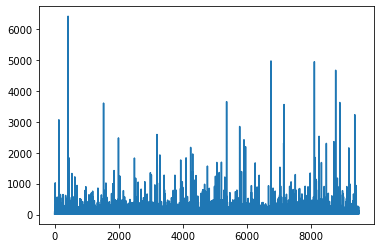

In [16]:
plt.plot(pixhistory2);

(array([7.267e+03, 1.104e+03, 3.940e+02, 2.220e+02, 1.110e+02, 8.800e+01,
        6.600e+01, 4.800e+01, 3.600e+01, 1.800e+01, 1.900e+01, 1.700e+01,
        1.600e+01, 1.400e+01, 7.000e+00, 5.000e+00, 5.000e+00, 3.000e+00,
        5.000e+00, 1.000e+01, 4.000e+00, 3.000e+00, 0.000e+00, 1.000e+00,
        2.000e+00, 3.000e+00, 2.000e+00, 1.000e+00, 5.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 3.000e+00, 0.000e+00, 2.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

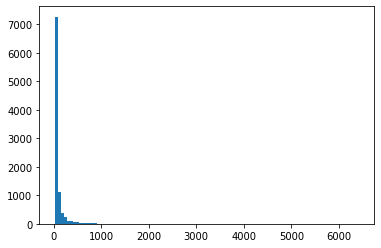

In [17]:
plt.hist(pixhistory2, bins=100)

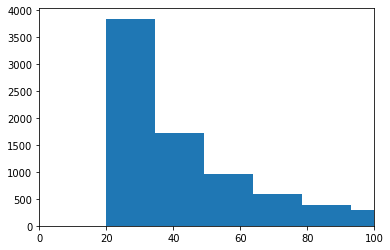

In [21]:
# zoom in
plt.xlim(0, 100)
plt.hist(pixhistory1, bins=1000);

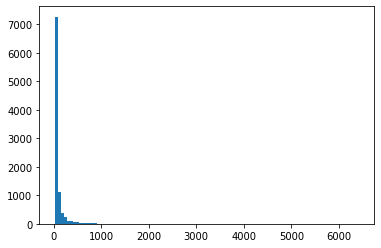

In [19]:
plt.hist(pixhistory2, bins=100);

(array([2.188e+03, 1.360e+03, 9.450e+02, 6.780e+02, 5.770e+02, 4.450e+02,
        3.400e+02, 2.900e+02, 2.320e+02, 2.120e+02, 1.950e+02, 1.510e+02,
        1.440e+02, 1.130e+02, 1.130e+02, 8.100e+01, 8.200e+01, 8.900e+01,
        7.100e+01, 6.500e+01, 6.500e+01, 4.700e+01, 5.000e+01, 3.600e+01,
        3.500e+01, 3.800e+01, 3.000e+01, 3.600e+01, 3.300e+01, 2.400e+01,
        2.500e+01, 2.500e+01, 2.300e+01, 2.600e+01, 2.500e+01, 1.500e+01,
        1.900e+01, 2.500e+01, 2.000e+01, 1.900e+01, 1.100e+01, 1.700e+01,
        7.000e+00, 1.500e+01, 1.200e+01, 1.100e+01, 1.100e+01, 6.000e+00,
        1.300e+01, 8.000e+00, 7.000e+00, 7.000e+00, 7.000e+00, 1.100e+01,
        9.000e+00, 1.000e+01, 1.600e+01, 6.000e+00, 9.000e+00, 6.000e+00,
        9.000e+00, 6.000e+00, 1.000e+01, 5.000e+00, 1.000e+01, 4.000e+00,
        8.000e+00, 7.000e+00, 3.000e+00, 4.000e+00, 7.000e+00, 6.000e+00,
        5.000e+00, 1.000e+00, 6.000e+00, 6.000e+00, 5.000e+00, 5.000e+00,
        3.000e+00, 4.000e+00, 3.000e+0

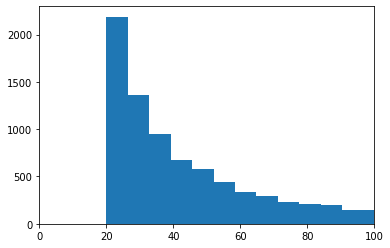

In [20]:
# zoom in
plt.xlim(0, 100)
plt.hist(pixhistory2, bins=1000)

## Play with Example
link : https://chi-feng.github.io/mcmc-demo/  
Compare each method and describe the expected pros and cons

( more to come... :\ )